# Applied Programming Lab: Week 2 Large Bonus
**by Niranjan A. Kartha (EE21B095)**

____

# Install the required packages

This notebook uses the `numpy` and `matplotlib` libraries which need to be installed for the cells to run without errors.

In [4]:
import numpy as np # for working with numbers
import timeit # for timing functions
import matplotlib.pyplot as plt

____

# SPICE

The below code blocks set up a `SpiceSolver` class which can be used to load and solve SPICE netlists, and also generate plots of transient voltages and currents. It is an extension of the code in the submission I have made for the main question in the  week 2 assignment.

## Transient analysis

At any instant of time, we can replace every capacitor in the circuit with a voltage source, and every inductor with a current source. This lets us calculate instantaneous voltage and current values.

We can use these instantaneous values to approximate the change in voltage and current values in the inductors and capacitors in the circuit.

$$\Delta V_C \approx \frac{I_C}{C} \Delta t$$

$$\Delta I_L \approx \frac{V_L}{L} \Delta t$$

Also, we can observe that $\mathbf{Y}$ does not change as the voltages and currents across a circuit. This means that we can reuse $\mathbf{Y}^{-1}$ for faster computation of the transient state.


## General classes

In [5]:
# an edge in the network that goes between two nodes
class Edge:
    def __init__(self, name, node_left, node_right):
        self.name = name
        self.node_left = node_left
        self.node_right = node_right
        
# a general passive component
class Passive(Edge):
    def __init__(self, name, node_left, node_right, value, cond=0):
        Edge.__init__(self, name, node_left, node_right)
        self.value = value
        self.cond = cond # condition, like voltage of a capacitor

# a general source (voltage or current)
class Source(Edge):
    def __init__(self, name, node_left, node_right, value, phase):
        Edge.__init__(self, name, node_left, node_right)
        self.value = value
        self.phase = phase

## Solver

In [6]:
# class that parses a spice file and solves it
class SpiceSolver:
    # throw an error specifying the line where the error occurred
    @staticmethod
    def __spice_err(line_index, line, message):
        raise Exception(
            f"SPICE ERROR on line {line_index + 1}:\n" +
            f"{line}\n" +
            message
        )
    
    # parse a float, and throw an error if it's not valid
    @staticmethod
    def __parse_float(x, line_index, line):
        try:
            x = float(x)
        except ValueError:
            SpiceSolver.__spice_err(line_index, line, f"couldn't parse as number: `{command[3]}`")
        return x
    
    # validate the number of arguments to a command
    @staticmethod
    def __assert_arg_count(command, expected, line_index, line):
        if len(command) not in expected:
            SpiceSolver.__spice_err(line_index, line, f"invalid number of arguments: expected {expected}, got {len(command)}")
    
    def __init__(self):
        # we will replace all nodes with numbers in our matrix
        # this map will remember the mapping between node names and the numbering we assign
        self.node_map = { "GND": 0 }
        
        # number of nodes (excluding ground)
        self.node_count = 0
        
        # lists of sources by frequency
        self.voltages = { 0: [] }
        self.currents = { 0: [] }
        
        # store a list of components
        self.resistors = []
        self.capacitors = []
        self.inductors = []
        
        # we represent the passive elements in the circuit as 3 weighted graphs where
        # components form edges:
        # one has conductances as its weights
        # one has capacitance as its weights
        # one has 1/inductance as its weights
        
        # we use the diagonal elements as the negative of the sum of the rest of the
        # values in the corresponding row (plus ground), since this is what appears
        # in the MNA matrix
        
        # adjacency matrix of conductances between nodes (excluding GND)
        self.conductance_matrix = None
        
        # adjacency matrix of capacitances between nodes (excluding GND)
        self.capacitance_matrix = None
        
        # adjacency matrix of 1/inductances between nodes (excluding GND)
        self.inv_inductance_matrix = None
        
        # vector representing current transient state of the circuit
        self.transient_state = None
        
        # dictionary of extra nodes added in the transient_state vector
        self.transient_node_map = {}
        
        # we multiply this matrix with the current state of the circuit
        # to get the currents and voltages
        self.transient_matrix = None
    
    # read a file and create a representation of the circuit in memory
    def read_file(self, filename):
        # open file
        with open(filename) as f:
            l = f.readlines()
            
            if len(l) == 0: # make sure the file is not empty
                raise Exception("SPICE ERROR: empty file")

            # seek to start of circuit
            start = 0
            while len(l[start]) > 0 and l[start].split("#")[0].strip() != ".circuit":
                start += 1
                if start >= len(l): # we need to have a ".circuit" somewhere
                    raise Exception("SPICE ERROR: couldn't find start of circuit")
                    
            # find end of circuit
            end = start
            while len(l[end]) > 0 and l[end].split("#")[0].strip() != ".end":
                end += 1
                if end >= len(l): # we need to have a ".end" somewhere
                    raise Exception("SPICE ERROR: couldn't find end of circuit")
            
            # generate a dictionary of source names to frequencies based on the directives given after ".end"
            frequencies = {}
            
            # loop through lines after the ".end" directive
            for i in range(end + 1, len(l)):
                command = l[i].split('#')[0].split() # get command
                
                if command[0] == "": # if there's no command, move on
                    continue
                
                # look for and parse ".ac" command
                if command[0].lower() == ".ac":
                    self.__assert_arg_count(command, [3], i, l[i])
                    
                    if command[1].upper() in frequencies: # each source should have its frequency defined only once
                        self.__spice_error(i, l[i], "redefinition of freqency")
                        
                    # add frequency to dictionary
                    freq = self.__parse_float(command[2], i, l[i])
                    frequencies[command[1].upper()] = freq

                    self.voltages[freq] = []
                    self.currents[freq] = []
                else:
                    pass # we don't need to throw errors if there is garbage after the ".end"
            
            # generate a list of nodes and components, and check syntax
            for i in range(start + 1, end): # loop through the ".circuit" section
                command = l[i].split('#')[0].split()

                if command[0] == "":
                    continue
                    
                if len(command) < 4: # all commands have at least 4 arguments
                    self.__spice_error(i, l[i], "invalid number of arguments")
                
                # the second and third arguments will contain node names
                # add the nodes mentioned to our node map if they aren't already in it
                for j in [1, 2]:
                    node_name = command[j]
                    if node_name.upper() not in self.node_map:
                        self.node_count += 1
                        self.node_map[node_name.upper()] = self.node_count
                
                # type of component
                ctype = l[i][0].upper()

                # parse passive components
                if ctype in ["R", "L", "C"]:
                    self.__assert_arg_count(command, [4, 5], i, l[i])
                    
                    edge = Passive(
                        command[0],
                        self.node_map[command[1].upper()],
                        self.node_map[command[2].upper()],
                        self.__parse_float(command[3], i, l[i])
                    )
                    
                    if len(command) == 5: # if an initial condition is specified (5th argument), set it
                        edge.cond = self.__parse_float(command[4], i, l[i])
                        
                    # add value to list
                    if ctype == "R":
                        self.resistors.append(edge)
                    elif ctype == "L":
                        self.inductors.append(edge)
                    else:
                        self.capacitors.append(edge)
                        
                # parse sources
                elif ctype in ["V", "I"]:
                    freq = 0
                    phase = 0
                    
                    # check type of source
                    if command[3].lower() == "ac":
                        self.__assert_arg_count(command, [6], i, l[i])
                        
                        # look up our frequencies dictionary for this source
                        if command[0].upper() in frequencies:
                            freq = frequencies[command[0].upper()]
                            phase = self.__parse_float(command[5], i, l[i])
                        else: # throw an error if the frequency for this source is not defined
                            self.__spice_error(i, l[i], f"could not find frequency for AC source: `{command[0]}`")
            
                    elif command[3].lower() == "dc":
                        self.__assert_arg_count(command, [5], i, l[i])
                        
                    else:
                        self.__spice_error(i, l[i], f"invalid source type: `{command[3]}`")
                    
                    edge = Source(
                        command[0],
                        self.node_map[command[1].upper()],
                        self.node_map[command[2].upper()],
                        self.__parse_float(command[4], i, l[i]),
                        phase,
                    )
                    
                    if ctype == "V":
                        self.voltages[freq].append(edge)
                    else:
                        self.currents[freq].append(edge)
                        
                else:
                    self.__spice_error(i, l[i], "unidentified command inside circuit")
                    
        # delete GND
        del self.node_map["GND"]
        
        # now use the data we have parsed to generate matrices
        self.__gen_matrices()
    
    # generate conductance, capacitance and inverse-inductance matrices
    def __gen_matrices(self):
        # initialize to zeroes
        self.conductance_matrix = np.zeros((self.node_count, self.node_count))
        self.capacitance_matrix = np.zeros((self.node_count, self.node_count))
        self.inv_inductance_matrix = np.zeros((self.node_count, self.node_count))
        
        # conductance matrix
        for r in self.resistors:
            low = min(r.node_left, r.node_right) - 1
            high = max(r.node_left, r.node_right) - 1
            if low == -1:
                # if the resistor is between ground and a node, add it to the diagonal
                self.conductance_matrix[high][high] += 1 / r.value
            else:
                self.conductance_matrix[low][high] += 1 / r.value
                
        # capacitance matrix
        for c in self.capacitors:
            low = min(c.node_left, c.node_right) - 1
            high = max(c.node_left, c.node_right) - 1
            if low == -1:
                self.capacitance_matrix[high][high] += c.value
            else:
                self.capacitance_matrix[low][high] += c.value
                
        # inverse-inductance matrix
        for l in self.inductors:
            low = min(l.node_left, l.node_right) - 1
            high = max(l.node_left, l.node_right) - 1
            if low == -1:
                self.inv_inductance_matrix[high][high] += 1 / l.value
            else:
                self.inv_inductance_matrix[low][high] += 1 / l.value
        
        # mirror our matrices and fix the diagonal elements
        mats = [self.conductance_matrix, self.inv_inductance_matrix, self.capacitance_matrix]
        for mat in mats:
            for i in range(self.node_count):
                # set diagonal elements
                for j in range(0, i):
                    mat[i][i] -= mat[j][i]
                    
                # mirror
                for j in range(i + 1, self.node_count):
                    mat[i][i] -= mat[i][j]
                    mat[j][i] = mat[i][j]
        
    # create a linear matrix equation A x = b for MNA (returns A and b)
    def __gen_mna_pair(self, modified_voltages, freq):
        w = 2j * np.pi * freq
        
        dim = self.node_count + len(modified_voltages) # number of dimensions in matrix
        
        mat = np.zeros((dim, dim), dtype=np.complex_)
        x = np.zeros(dim, dtype=np.complex_)
        
        
        if w != 0:
            mat[0:self.node_count, 0:self.node_count] = self.conductance_matrix + \
                                                        1j * w * self.capacitance_matrix + \
                                                        1 / (1j * w) * self.inv_inductance_matrix
        else:
            mat[0:self.node_count, 0:self.node_count] = self.conductance_matrix
            
        # outward currents are taken as positive, active sign convention is followed for voltage sources
        
        k = self.node_count
        
        # create MNA matrix
        
        # add equations of the form V_left - V_right = V_source
        # and also currents on the RHS of KCL equations
        for v in modified_voltages:
            if v.node_left != 0:
                mat[v.node_left - 1][k] = -1 # current
                mat[k][v.node_left - 1] = 1 # voltage
                
            if v.node_right != 0:
                mat[v.node_right - 1][k] = 1 # current
                mat[k][v.node_right - 1] = -1 # voltage
            
            x[k] = v.value * np.exp(1j * v.phase)
            
            k += 1
            
        for i in self.currents[freq]:
            if i.node_left != 0:
                x[i.node_left - 1] = i.value * (np.exp(1j * i.phase))
                
            if i.node_right != 0:
                x[i.node_right - 1] = -i.value * (np.exp(1j * i.phase))
            
        return (mat, x)
    
    # generate modified voltage sources according to frequency and solve,
    # returning a dictionary of nodes to voltages/currents
    def __solve_freq(self, freq):
        modified_voltages = []
        
        # map of extra nodes that we have added
        extra_nodes = {}
        
        # convert inductors to 0-voltage sources for DC
        if freq == 0:
            for l in self.inductors:
                modified_voltages.append(
                    Source(l.name, l.node_left, l.node_right, 0, 0)
                )
        
        for f in self.voltages:
            # if the source is at a different frequency, short it
            if freq != f:
                for v in self.voltages[f]:
                    modified_voltages.append(
                        Source(v.name, v.node_left, v.node_right, 0, 0)
                    )
            else:
                for v in self.voltages[f]:
                    modified_voltages.append(v)
        
        # keep track of where each voltage is
        new_node_count = self.node_count
        for v in modified_voltages:
            new_node_count += 1
            extra_nodes[f"I_{v.name}"] = new_node_count
        
        solution = solve(*self.__gen_mna_pair(modified_voltages, freq))
        
        if freq == 0:
            solution = np.real(solution)
        
        result = {}
        
        for key in self.node_map:
            result[f"V_{key}"] = solution[self.node_map[key] - 1]
            
        for key in extra_nodes:
            result[key] = solution[extra_nodes[key] - 1]
            
        return result
    
    # intitialize transient matrix, vector and node map
    def __transient_init(self):
        transient_voltages = []
        transient_currents = []
        
        # add voltage sources
        for freq in self.voltages:
            for v in self.voltages[freq]:
                transient_voltages.append(
                    Source(v.name, v.node_left, v.node_right, v.value * np.cos(v.phase), 0)
                )
            
        # add capacitors
        for c in self.capacitors:
            transient_voltages.append(
                Source(f"I_{c.name}", c.node_left, c.node_right, c.cond, 0)
            )
        
        # add current sources
        for freq in self.currents:
            for i in self.currents[freq]:
                new_node_count += 1
                
                transient_currents.append(
                    Source(i.name, i.node_left, i.node_right, i.value * np.cos(i.phase), 0)
                )
                
        # add inductors
        for l in self.inductors:
            transient_currents.append(
                Source(f"I_{l.name})", l.node_left, l.node_right, l.cond, 0)
            )
        
        dim = self.node_count + len(transient_voltages) # number of dimensions in matrix
        
        # the matrix that we will solve to obtain the transient state
        mat = np.zeros((dim, dim))
        x = np.zeros(dim)
        
        mat[0:self.node_count, 0:self.node_count] = self.conductance_matrix
        
        # outward currents are taken as negative, active sign convention is followed for voltage sources
        
        # as we add extra nodes to our nodal analysis equation, this variable keeps track of the index of
        # the node added
        k = self.node_count
        
        for v in transient_voltages:
            # V_left - V_right = V_source
            
            if v.node_left != 0:
                mat[v.node_left - 1][k] = -1 # current
                mat[k][v.node_left - 1] = 1 # voltage
                
            if v.node_right != 0:
                mat[v.node_right - 1][k] = 1 # current
                mat[k][v.node_right - 1] = -1 # voltage
            
            x[k] = v.value
            k += 1
            self.transient_node_map[v.name] = k
            
        for i in transient_currents:
            if i.node_left != 0:
                x[i.node_left - 1] = i.value
                
            if i.node_right != 0:
                x[i.node_right - 1] = -i.value
        
        self.transient_matrix = np.linalg.inv(mat)
        self.transient_state = x
    
    # perform one small step in our simulation, updating our transient voltages and currents
    def __transient_step(self, t, dt):
        sol = self.transient_matrix.dot(self.transient_state)
        
        # index of added variable in MNA equation
        k = self.node_count
        
        # update voltage sources
        for freq in self.voltages:
            for v in self.voltages[freq]:
                self.transient_state[k] = v.value * np.cos(v.phase + 2 * np.pi * freq * t)
                k += 1
            
        # nudge voltages in capacitors
        for c in self.capacitors:
            self.transient_state[k] += sol[k] * dt / c.value
            k += 1
                
        # update current sources
        for freq in self.currents:
            for i in self.currents[freq]:
                val = i.value * np.cos(i.phase + 2 * np.pi * freq * t)
                if i.node_left != 0:
                    self.transient_state[i.node_left - 1] = val

                if i.node_right != 0:
                    self.transient_state[i.node_right - 1] = -val
        
        # nudge currents in inductors
        for l in self.inductors:
            v = 0 # voltage across inductor
            val = 0
            
            # passive sign convention - current flows from left node to right node
            if l.node_left != 0:
                v += sol[l.node_left - 1]
                val = self.transient_state[l.node_left - 1]
            if l.node_right != 0:
                v -= sol[l.node_right - 1]
                val = self.transient_state[l.node_right - 1]
            
            val += v / l.value * dt
            
            if l.node_left != 0:
                self.transient_state[l.node_left - 1] = val
            if l.node_right != 0:
                self.transient_state[l.node_right - 1] = val
        
        return sol
    
    # approximate the transient state of a circuit and return the readings at a specified sample rate
    def transient_response(self, total_time, dt, sample_rate):
        self.__transient_init()
        
        n = int(total_time / dt)
        values = {}
        
        samples = int(total_time * sample_rate)
        sample_interval = n // samples
        
        for key in self.node_map:
            values[f"V_{key}"] = [0] * samples
        for key in self.transient_node_map:
            values[key] = [0] * samples
        
        for i in range(n):
            step = self.__transient_step(i / n * total_time, dt)
            
            if i % sample_interval == 0:
                for key in self.node_map:
                    values[f"V_{key}"][i // sample_interval] = step[self.node_map[key] - 1]
                for key in self.transient_node_map:
                    values[key][i // sample_interval] = step[self.transient_node_map[key] - 1]
        return values
        
    # print the steady state solution of the system
    def solve_steady(self):
        for freq in self.voltages:
            print(f"frequency {freq}:")
            print()
            try:
                sol = self.__solve_freq(freq)
                for key in sol:
                    print(f"{key:<10}{sol[key]}")
            except ZeroDivisionError:
                print("no steady state at this frequency")

            print()
            print("=" * 20)
            print()

We can simulate a transient response as follows:

In [8]:
solver = SpiceSolver()
solver.read_file("spice/rlc.netlist")
measurement = solver.transient_response(50, 0.001, 100)

And now we can plot it using matplotlib

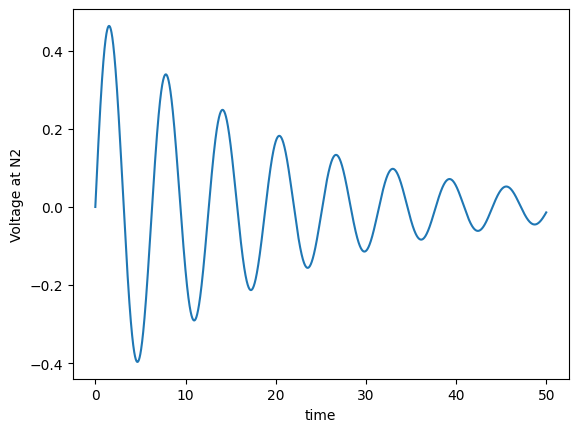

In [9]:
plt.plot(np.arange(0, 50, 0.01), measurement["V_N2"])
plt.ylabel("Voltage at N2")
plt.xlabel("time")
plt.show()